# Bitcoin investment analysis

The aim of the current notebook is to generate a useful recommendation on bitcoin investment while addressing the following points:

* How does the performance of Bitcoin compare to the S&P 500 and the price of gold?
* bitcoin's returns and volatility analysis
* Could it help improve the performance of a portfolio? 
* Could Bitcoin be used as a hedge versus inflation?
* a portfolio construction using bitcoin, S&P 500, and gold: make a recommendation that minimizes overall risk.

## 💾 The data

#### Bitcoin daily data in US dollars
- "date" - date from September 17, 2014 to November 17, 2021
- "open" - the price at the beginning of the trading day
- "high" - the highest price reached that day
- "low" - the lowest price reached that day
- "close" - the price at the closing of the trading day
- "volume" - how many Bitcoin were traded that day

#### S&P 500 daily data
- "date" - date from September 17, 2014 to November 17, 2021
- "open" - the index level at the beginning of the trading day
- "high" - the highest level reached that day
- "low" - the lowest level reached that day
- "close" - the level at the closing of the trading day
- "volume" - how many shares in the companies that make up the index were traded that day

#### inflation and gold as monthly data
- "date" - date from September, 2014 to November, 2021
- "gold_usd" - price in usd of gold for that month
- "cpi_us" - the inflation index for the US for that month (cpi = consumer price index)

_CPI data from the [U.S. Bureau of Labor Statistics](https://www.bls.gov/cpi/). Publicly available information_.

## Importing some packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importing the data

In [1]:
bitcoin = pd.read_csv('./data/bitcoin-usd.csv', parse_dates=['date'])
bitcoin.head()

,date,open,high,low,close,volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0


In [2]:
sp500 = pd.read_csv('./data/sp500.csv', parse_dates=['date'])
sp500.head()

,date,open,high,low,close,volume
0,2014-09-17,1999.300049,2010.739990,1993.290039,2001.569946,3209420000
1,2014-09-18,2003.069946,2012.339966,2003.069946,2011.359985,3235340000
2,2014-09-19,2012.739990,2019.260010,2006.589966,2010.400024,4880220000
3,2014-09-22,2009.079956,2009.079956,1991.010010,1994.290039,3349670000
4,2014-09-23,1992.780029,1995.410034,1982.770020,1982.770020,3279350000


In [3]:
monthly_data = pd.read_csv('./data/monthly_data.csv', parse_dates=['date'])
monthly_data.head()

,date,gold_usd,cpi_us
0,2014-09-01,1241.330,237.852
1,2014-10-01,1223.565,238.031
2,2014-11-01,1176.413,237.433
3,2014-12-01,1200.440,236.151
4,2015-01-01,1249.333,234.812


As dates for monthly_data are presented as of the first day of each month, let's replace the first day of a month with its last day. This is done just for convenience.

In [ ]:
monthly_data['date'] = monthly_data['date'] + pd.tseries.offsets.MonthEnd(0)
monthly_data.head()

,date,gold_usd,cpi_us
0,2014-09-30,1241.330,237.852
1,2014-10-31,1223.565,238.031
2,2014-11-30,1176.413,237.433
3,2014-12-31,1200.440,236.151
4,2015-01-31,1249.333,234.812


## Exploring the data

In [ ]:
bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2619 entries, 0 to 2618
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2619 non-null   datetime64[ns]
 1   open    2615 non-null   float64       
 2   high    2615 non-null   float64       
 3   low     2615 non-null   float64       
 4   close   2615 non-null   float64       
 5   volume  2615 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 122.9 KB


So bitcoin contains some missing values. Let's have a look.

In [ ]:
bitcoin[bitcoin['open'].isnull()]

,date,open,high,low,close,volume
2039,2020-04-17,NaN,NaN,NaN,NaN,NaN
2214,2020-10-09,NaN,NaN,NaN,NaN,NaN
2217,2020-10-12,NaN,NaN,NaN,NaN,NaN
2218,2020-10-13,NaN,NaN,NaN,NaN,NaN


Let's drop the missing values.

In [ ]:
bitcoin.dropna(inplace=True)
bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2615 entries, 0 to 2618
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2615 non-null   datetime64[ns]
 1   open    2615 non-null   float64       
 2   high    2615 non-null   float64       
 3   low     2615 non-null   float64       
 4   close   2615 non-null   float64       
 5   volume  2615 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 143.0 KB


In [ ]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1805 entries, 0 to 1804
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1805 non-null   datetime64[ns]
 1   open    1805 non-null   float64       
 2   high    1805 non-null   float64       
 3   low     1805 non-null   float64       
 4   close   1805 non-null   float64       
 5   volume  1805 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 84.7 KB


The first thing we notice, by looking at the data of S&P 500, is that it contains less datapoints than bitcoin's data. The reason is that bitcoin trades literally everyday compared to S&P 500, which is traded only on trading days (252 or 253 days per year).

Finally, let's explore monthly_data. It does not contain any missing points as shown below.

In [ ]:
monthly_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      87 non-null     datetime64[ns]
 1   gold_usd  87 non-null     float64       
 2   cpi_us    87 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 2.2 KB


## Performance analysis

First of all let's replace indexing of the data with the corresponding dates.

In [ ]:
bitcoin.set_index('date', inplace=True)
sp500.set_index('date', inplace=True)
monthly_data.set_index('date', inplace=True)

As bitcoin and S&P500 data are daily, we can compare their performance on daily basis. Namely let's divide each series by their value as of September 17, 2014 (daily series start at this date). This will make the series start at 1 or we can multiply them by 100 to start at 100. Anyway this procedure is nothing but representing the series in the form of cumulative growth. So let's focus on close and average prices. Average price is the average of low, high, open, and close prices. 

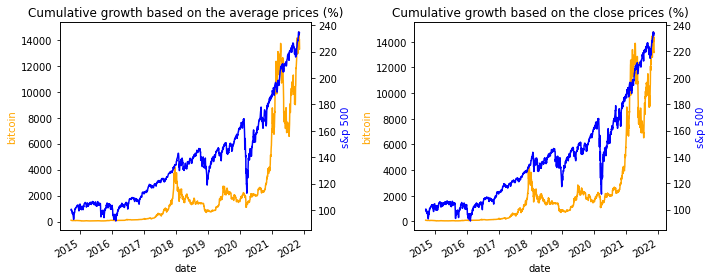

In [ ]:
sp500['average'] = sp500.drop('volume', axis=1).mean(axis=1)
sp500['cum_growth_av'] = sp500['average'].div(sp500['average'].iloc[0]).mul(100)
sp500['cum_growth_close'] = sp500['close'].div(sp500['close'].iloc[0]).mul(100)

bitcoin['average'] = bitcoin.drop('volume', axis=1).mean(axis=1)
bitcoin['cum_growth_av'] = bitcoin['average'].div(bitcoin['average'].iloc[0]).mul(100)
bitcoin['cum_growth_close'] = bitcoin['close'].div(bitcoin['close'].iloc[0]).mul(100)

fig = plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
ax = bitcoin['cum_growth_av'].plot(color='orange')
ax2 = sp500['cum_growth_av'].plot(color='blue', secondary_y=True, ax=ax)
plt.title('Cumulative growth based on the average prices (%)')
ax.set_ylabel('bitcoin', color='orange')
ax2.set_ylabel('s&p 500', color='blue')

plt.subplot(1, 2, 2)
ax = bitcoin['cum_growth_close'].plot(color='orange')
ax2 = sp500['cum_growth_close'].plot(color='blue', secondary_y=True, ax=ax)
plt.title('Cumulative growth based on the close prices (%)')
ax.set_ylabel('bitcoin', color='orange')
ax2.set_ylabel('s&p 500', color='blue')

plt.tight_layout()
plt.show()

In terms of cumulative daily growth bitcoin outperforms the index as shown above. Now let's investigate daily returns.

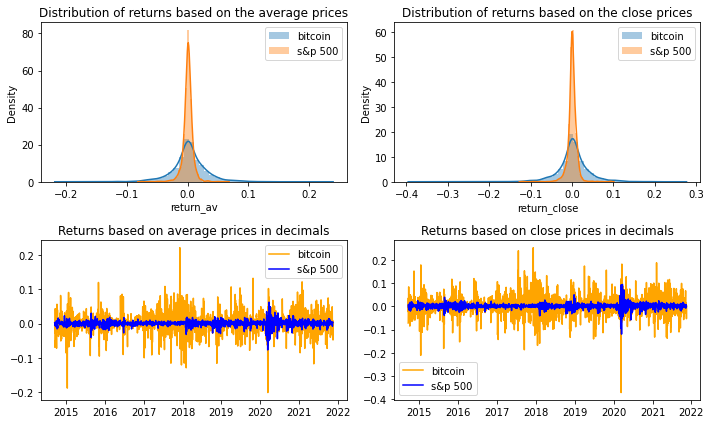

In [ ]:
bitcoin['return_av'] = bitcoin['average'].pct_change()
bitcoin['return_close'] = bitcoin['close'].pct_change()

sp500['return_av'] = sp500['average'].pct_change()
sp500['return_close'] = sp500['close'].pct_change()

fig = plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
sns.distplot(bitcoin['return_av'], label='bitcoin')
sns.distplot(sp500['return_av'], label='s&p 500')
plt.legend()
plt.title('Distribution of returns based on the average prices')

plt.subplot(2, 2, 2)
sns.distplot(bitcoin['return_close'], label='bitcoin')
sns.distplot(sp500['return_close'], label='s&p 500')
plt.legend()
plt.title('Distribution of returns based on the close prices')

plt.subplot(2, 2, 3)
plt.plot(bitcoin['return_av'], color='orange', label='bitcoin')
plt.plot(sp500['return_av'], color='blue', label='s&p 500')
plt.legend()
plt.title('Returns based on average prices in decimals')

plt.subplot(2, 2, 4)
plt.plot(bitcoin['return_close'], color='orange', label='bitcoin')
plt.plot(sp500['return_close'], color='blue', label='s&p 500')
plt.legend()
plt.title('Returns based on close prices in decimals')

plt.tight_layout()
plt.show()

The plots above show that extreme returns are more probable to occur in case of bitcoin investment. Hence bitcoin is more volatile than S&P 500. Let's make more thorough analysis.

In [ ]:
# Calculating annualized average return and volatility for bitcoin
bitcoin_av_anr = (1 + bitcoin['return_av'].mean()) ** 360 - 1
bitcoin_close_anr = (1 + bitcoin['return_close'].mean()) ** 360 - 1

bitcoin_av_av = bitcoin['return_av'].std() * np.sqrt(360)
bitcoin_close_av = bitcoin['return_close'].std() * np.sqrt(360)

# Calculating annualized average return and volatility for S&P 500
sp500_av_anr = (1 + sp500['return_av'].mean()) ** 252 - 1
sp500_close_anr = (1 + sp500['return_close'].mean()) ** 252 - 1

sp500_av_av = sp500['return_av'].std() * np.sqrt(252)
sp500_close_av = sp500['return_close'].std() * np.sqrt(252)

# Setting risk free rate to current (05.01.2022) US Tbill rate with 4 weeks maturity
rfr = 0.05

# Calculating Sharpe ratio
bitcoin_av_sr = (bitcoin_av_anr - rfr) / bitcoin_av_av
bitcoin_close_sr = (bitcoin_close_anr - rfr) / bitcoin_close_av

sp500_av_sr = (sp500_av_anr - rfr) / sp500_av_av
sp500_close_sr = (sp500_close_anr - rfr) / sp500_close_av

# Calculating downside risk
bitcoin_av_dr = bitcoin[bitcoin['return_av']<0]['return_av'].std() * np.sqrt(252)
bitcoin_close_dr = bitcoin[bitcoin['return_close']<0]['return_close'].std() * np.sqrt(252)

sp500_av_dr = sp500[sp500['return_av']<0]['return_av'].std() * np.sqrt(252)
sp500_close_dr = sp500[sp500['return_close']<0]['return_close'].std() * np.sqrt(252)

# Calculating VAR with 95 % confidence level
bitcoin_av_var = np.percentile(bitcoin['return_av'].dropna(), 5)
bitcoin_close_var = np.percentile(bitcoin['return_close'].dropna(), 5)

sp500_av_var = np.percentile(sp500['return_av'].dropna(), 5)
sp500_close_var = np.percentile(sp500['return_close'].dropna(), 5)

# Calculating VAR with 99 % confidence level
bitcoin_av_var2 = np.percentile(bitcoin['return_av'].dropna(), 1)
bitcoin_close_var2 = np.percentile(bitcoin['return_close'].dropna(), 1)

sp500_av_var2 = np.percentile(sp500['return_av'].dropna(), 1)
sp500_close_var2 = np.percentile(sp500['return_close'].dropna(), 1)

# Calculating conditional VAR for 95 % confidence level
bitcoin_av_cvar = bitcoin[bitcoin['return_av'] < bitcoin_av_var]['return_av'].mean()
bitcoin_close_cvar = bitcoin[bitcoin['return_close'] < bitcoin_close_var]['return_close'].mean()

sp500_av_cvar = sp500[sp500['return_av'] < sp500_av_var]['return_av'].mean()
sp500_close_cvar = sp500[sp500['return_close'] < sp500_close_var]['return_close'].mean()

# Calculating conditional VAR for 99 % confidence level
bitcoin_av_cvar2 = bitcoin[bitcoin['return_av'] < bitcoin_av_var2]['return_av'].mean()
bitcoin_close_cvar2 = bitcoin[bitcoin['return_close'] < bitcoin_close_var2]['return_close'].mean()

sp500_av_cvar2 = sp500[sp500['return_av'] < sp500_av_var2]['return_av'].mean()
sp500_close_cvar2 = sp500[sp500['return_close'] < sp500_close_var2]['return_close'].mean()

performance_daily = pd.DataFrame({
    'series': ['bitcoin average price', 's&p 500 average price', 
               'bitcoin close price', 's&p 500 close price'],
    'return': [bitcoin_av_anr, sp500_av_anr, 
               bitcoin_close_anr, sp500_close_anr],
    'volatility': [bitcoin_av_av, sp500_av_av, 
                   bitcoin_close_av, sp500_close_av],
    'Sharpe ratio': [bitcoin_av_sr, sp500_av_sr, 
                     bitcoin_close_sr, sp500_close_sr],
    'downside risk': [bitcoin_av_dr, sp500_av_dr, 
                      bitcoin_close_dr, sp500_close_dr],
})

display(performance_daily)

risk_daily = pd.DataFrame({
    'series': ['bitcoin average price', 's&p 500 average price', 
               'bitcoin close price', 's&p 500 close price'],
    'VAR_95': [bitcoin_av_var, sp500_av_var, 
               bitcoin_close_var, sp500_close_var],
    'CVAR_95': [bitcoin_av_cvar, sp500_av_cvar, 
                bitcoin_close_cvar, sp500_close_cvar],
    'VAR_99': [bitcoin_av_var2, sp500_av_var2, 
               bitcoin_close_var2, sp500_close_var2],
    'CVAR_99': [bitcoin_av_cvar2, sp500_av_cvar2, 
                bitcoin_close_cvar2, sp500_close_cvar2]
})

display(risk_daily)

,series,return,volatility,Sharpe ratio,downside risk
0,bitcoin average price,1.278340,0.546946,2.245814,0.345369
1,s&p 500 average price,0.135859,0.130482,0.658017,0.115909
2,bitcoin close price,1.582611,0.741009,2.068276,0.475010
3,s&p 500 close price,0.144222,0.178416,0.528099,0.155118


,series,VAR_95,CVAR_95,VAR_99,CVAR_99
0,bitcoin average price,-0.044139,-0.067163,-0.074104,-0.105219
1,s&p 500 average price,-0.011898,-0.020808,-0.026300,-0.038238
2,bitcoin close price,-0.060050,-0.090948,-0.107087,-0.144769
3,s&p 500 close price,-0.016207,-0.027700,-0.032849,-0.049499


Note:
```
Return, volatility, and downside risk are annulized in the table above. There is no 
percentage value in the tables: all are in decimals.
```
<br> Once more the tables above show that bitcoin is more volatile. Moreover one can expect to lose daily not more than 4 or 6 %  (VAR_95 in the table) and 7 or 10 % (VAR_99 in the table) of her/his investment in bitcoin with 95 and 99 % confidence respectively. In addition CVAR for 95 and 99 % confidence levels are -6 or -9 % and -10 or -14 % respectively. CVAR represents historical mean of returns which are below VAR.
<br> Sharpe ratio adjusts excess return (expected asset return minus [risk free rate](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=billrates)) by risk (volatility) allowing to compare investments. It shows how much excess return one obtains/gains for 1 unit of risk. Generally Sharpe ratio above 1 is considered good. In case of bitcoin the ratio is slightly above 2 in both cases while it is below 1 for S&P 500. Hence Sharpe ratio suggests that bitcoin investment is better at least historically. But let's not forget about high volatility of bitcoin, which can make investors think twice. Anyway it is all about an investor's risk appetite.
<br> Now let's convert the daily data into monthly frequency using only close prices of the last day of each month. Afterwards let's merge the obtained monthly data to monthly_data dataset.

In [ ]:
sp500_close = sp500['close'].resample('M').last()
bitcoin_close = bitcoin['close'].resample('M').last()
temp_data = pd.concat([sp500_close, bitcoin_close], axis=1)
temp_data.columns = ['sp500', 'bitcoin']
temp_data.dropna(inplace=True)
monthly_data = pd.concat([monthly_data, temp_data], axis=1)
monthly_data.info()
monthly_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87 entries, 2014-09-30 to 2021-11-30
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gold_usd  87 non-null     float64
 1   cpi_us    87 non-null     float64
 2   sp500     87 non-null     float64
 3   bitcoin   87 non-null     float64
dtypes: float64(4)
memory usage: 3.4 KB


,gold_usd,cpi_us,sp500,bitcoin
date,,,,
2014-09-30,1241.330,237.852,1972.290039,386.944000
2014-10-31,1223.565,238.031,2018.050049,338.321014
2014-11-30,1176.413,237.433,2067.560059,378.046997
2014-12-31,1200.440,236.151,2058.899902,320.192993
2015-01-31,1249.333,234.812,1994.989990,217.464005


As we have CPI data, we can calculate monthly inflation adjusted cumulative returns for bitcoin, S&P 500, and gold. This is done below.

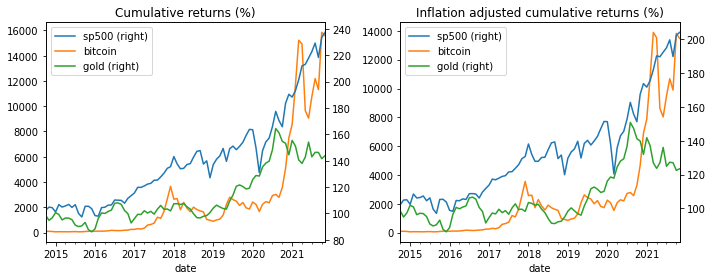

In [ ]:
m_return_data = monthly_data.pct_change().dropna()
m_return_data.rename(columns={'cpi_us': 'inflation', 
                              'gold_usd': 'gold'}, 
                     inplace=True)

asset_list = ['sp500', 'bitcoin',  'gold']
m_adj_return_data = m_return_data[asset_list].\
                    sub(m_return_data['inflation'], axis=0)

fig, axes = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)
m_return_data[asset_list].add(1).cumprod(axis=0).mul(100).\
plot(secondary_y=['gold', 'sp500'], 
     title='Cumulative returns (%)',
     ax=axes[0])
m_adj_return_data.add(1).cumprod(axis=0).mul(100).\
plot(secondary_y=['gold', 'sp500'], 
     title='Inflation adjusted cumulative returns (%)',
     ax=axes[1])
plt.tight_layout()
plt.show()

The charts above show that bitcoin outperformed gold and S&P 500 historically in terms of cumulative returns. Let's observe return distribution across the instruments.

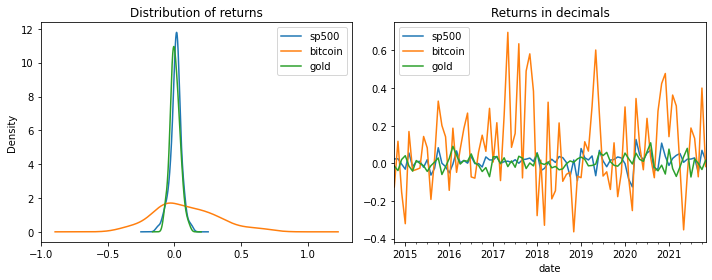

In [ ]:
fig, axes = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)
m_return_data[asset_list].plot(kind='kde', title='Distribution of returns', ax=axes[0])
m_return_data[asset_list].plot(title='Returns in decimals', ax=axes[1])
plt.tight_layout()
plt.show()

So we can conclude that bitcoin is the most volatile instrument compared to gold and S&P 500. Meanwhile we observe that gold and S&P 500 returns have almost the same distribution. Let's construct the table containing annualized return, volatility, Sharpe ratio, etc. 

In [ ]:
# Calculating annualized average return and volatility for bitcoin
bitcoin_anr = (1 + m_return_data['bitcoin'].mean()) ** 12 - 1
sp500_anr = (1 + m_return_data['sp500'].mean()) ** 12 - 1
gold_anr = (1 + m_return_data['gold'].mean()) ** 12 - 1

bitcoin_av = m_return_data['bitcoin'].std() * np.sqrt(12)
sp500_av = m_return_data['sp500'].std() * np.sqrt(12)
gold_av = m_return_data['gold'].std() * np.sqrt(12)

# Setting risk free rate to current (05.01.2022) US Tbill rate with 4 weeks maturity
rfr = 0.05

# Calculating Sharpe ratio
bitcoin_sr = (bitcoin_anr - rfr) / bitcoin_av
sp500_sr = (sp500_anr - rfr) / sp500_av
gold_sr = (gold_anr - rfr) / gold_av

# Calculating downside risk
bitcoin_dr = m_return_data[m_return_data['bitcoin']<0]['bitcoin'].std() * np.sqrt(12)
sp500_dr = m_return_data[m_return_data['sp500']<0]['sp500'].std() * np.sqrt(12)
gold_dr = m_return_data[m_return_data['gold']<0]['gold'].std() * np.sqrt(12)

# Calculating VAR with 95 % confidence level
bitcoin_var = np.percentile(m_return_data['bitcoin'], 5)
sp500_var = np.percentile(m_return_data['sp500'], 5)
gold_var = np.percentile(m_return_data['gold'], 5)

# Calculating VAR with 99 % confidence level
bitcoin_var2 = np.percentile(m_return_data['bitcoin'], 1)
sp500_var2 = np.percentile(m_return_data['sp500'], 1)
gold_var2 = np.percentile(m_return_data['gold'], 1)

# Calculating conditional VAR for 95 % confidence level
bitcoin_cvar = m_return_data[m_return_data['bitcoin'] < bitcoin_var]['bitcoin'].mean()
sp500_cvar = m_return_data[m_return_data['sp500'] < sp500_var]['sp500'].mean()
gold_cvar = m_return_data[m_return_data['gold'] < gold_var]['gold'].mean()

# Calculating conditional VAR for 99 % confidence level
bitcoin_cvar2 = m_return_data[m_return_data['bitcoin'] < bitcoin_var2]['bitcoin'].mean()
sp500_cvar2 = m_return_data[m_return_data['sp500'] < sp500_var2]['sp500'].mean()
gold_cvar2 = m_return_data[m_return_data['gold'] < gold_var2]['gold'].mean()

performance_monthly = pd.DataFrame({
    'series': ['bitcoin', 's&p 500', 'gold'],
    'return': [bitcoin_anr, sp500_anr, gold_anr],
    'volatility': [bitcoin_av, sp500_av, gold_av],
    'Sharpe ratio': [bitcoin_sr, sp500_sr, gold_sr],
    'downside risk': [bitcoin_dr, sp500_dr, gold_dr],
})

display(performance_monthly)

risk_monthly = pd.DataFrame({
    'series': ['bitcoin', 's&p 500', 'gold'],
    'VAR_95': [bitcoin_var, sp500_var, gold_var],
    'CVAR_95': [bitcoin_cvar, sp500_cvar, gold_cvar],
    'VAR_99': [bitcoin_var2, sp500_var2, gold_var2],
    'CVAR_99': [bitcoin_cvar2, sp500_cvar2, gold_cvar2]
})

display(risk_monthly)

,series,return,volatility,Sharpe ratio,downside risk
0,bitcoin,1.638161,0.795261,1.997031,0.344481
1,s&p 500,0.139566,0.142689,0.627703,0.111065
2,gold,0.060092,0.125309,0.080535,0.068499


,series,VAR_95,CVAR_95,VAR_99,CVAR_99
0,bitcoin,-0.271310,-0.329163,-0.355131,-0.364116
1,s&p 500,-0.064979,-0.087238,-0.096778,-0.125119
2,gold,-0.053565,-0.065943,-0.071298,-0.072679


Note:
```
Return, volatility, and downside risk are annulized in the table above. There is no 
percentage value in the tables: all are in decimals.
```
<br> The tables above show that bitcoin is the most volatile amongst the intruments. Moreover one can expect to lose monthly not more than 27 %  (VAR_95 in the table) and 35 % (VAR_99 in the table) of her/his investment in bitcoin with 95 and 99 % confidence respectively. In addition CVAR for 95 and 99 % confidence levels are -32 % and -36 % respectively. Please remember that CVAR represents historical mean of returns which are below VAR.
<br> Sharpe ratio, in case of bitcoin, is almost 2. While it is below 1 for S&P 500 and gold. Hence Sharpe ratio suggests that bitcoin investment is better at least historically. So it is well known that high return is accompanied with high risk.
<br> Let's see whether bitcoin can be considered as a hedge against inflation.

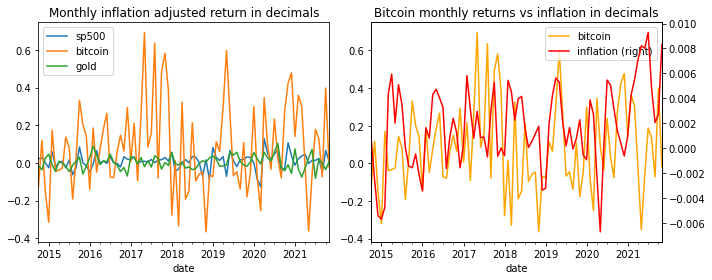

In [ ]:
fig, axes = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)
m_adj_return_data.plot(ax=axes[0], 
                       title='Monthly inflation adjusted return in decimals')
m_return_data[['bitcoin', 'inflation']].plot(ax=axes[1], secondary_y='inflation',
                                             color=['orange', 'red'],
                                             title='Bitcoin monthly returns vs inflation in decimals')
plt.tight_layout()
plt.show()

The plots above show that bitcoin is not an ideal hedge for inflation as:
1. it experienced huge declines and increases in the returns, at least historically, compared to the other instruments (S&P 500 and gold)
2. inflation and bitcoin not always move in the same direction, which can lead to really bad returns when bitcoin experiences a decline and inflation increases.
Therefore, if one inludes bitcoin in her/his portfolio as a hedge for inflation, she/he might be aware that instead of mitigating the inflation it could worsen the performance of the portfolio.
<br> Certainly bitcoin alone is a good choice for risk seeking investors. But it is definitely not an option to consider if you are looking for a low volatility. Though bitcoin, combined with another investment option which negatively correlates with it, can form a great investment portfolio.
<br> Let's check correlation matrix for bitcoin, S&P 500 and gold.

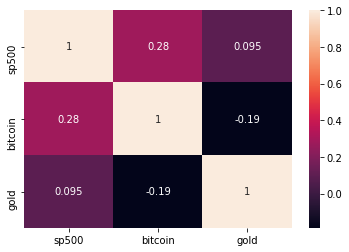

In [ ]:
temp_corr = m_return_data[asset_list].corr()
sns.heatmap(temp_corr, annot=True)
plt.show()

The heatmap above shows that bitcoin has negative correlation with gold. While S&P 500 is positively correlated with bitcoin. The correlation between gold and S&P 500 is negligible.
<br> Let's try to construct a portfolio using only these instruments and compare its performance with the individual instruments comprising it.
<br> <b>Side Note</b>:
```
I did not manage to install PyPortfolioOpt using the following command:

! pip install PyPortfolioOpt

Hence I decided to conduct portfolio optimization in google colab. The following code 
represents everything I did to obtain weights of the instruments in maximum Sharpe ratio
and minimum volatility portfolios.

# Importing pypfopt related funtionality
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt.cla import CLA

# Getting expected annualized return and covariance matrix
mu = expected_returns.mean_historical_return(m_return_data[asset_list], 
                                             frequency=12, 
                                             returns_data=True)
Sigma = risk_models.sample_cov(m_return_data[asset_list], 
                               returns_data=True, 
                               frequency=12)

# Obtaining efficient frontier
ef = EfficientFrontier(mu, Sigma)

# Selecting a portfolio with maximum Sharpe ratio
ef.max_sharpe(risk_free_rate=0.05)
print(ef.clean_weights())

Output: 
('sp500', 0.27734), ('bitcoin', 0.33146), ('gold', 0.3912)

# Obtaining efficient frontier
ef = EfficientFrontier(mu, Sigma)

# Selecting a portfolio with minimum volatility
ef.min_volatility()
print(ef.clean_weights())

Output:
('sp500', 0.40551), ('bitcoin', 0.0117), ('gold', 0.58279)

# As a sample covariance matrix is unbiased but inefficient, 
# let's apply Ledoit-Wolf covariance shrinkage technique 
# to make it efficient 
Sigma_eff = risk_models.CovarianceShrinkage(m_return_data[asset_list], 
                                            returns_data=True, 
                                            frequency=12).ledoit_wolf()

# Obtaining minimum volatility portfolio using the efficient covariance matrix
cla = CLA(mu, Sigma_eff)
cla.min_volatility()
print(cla.clean_weights())

Output:
('sp500', 0.42961), ('bitcoin', 0.01624), ('gold', 0.55415)

# Getting maximum Sharpe ratio portfolio using the efficient covariance matrix
cla = CLA(mu, Sigma_eff)
cla.max_sharpe()
print(cla.clean_weights())

Output:
('sp500', 0.34649), ('bitcoin', 0.21647), ('gold', 0.43703)
```
Hence let's just use the weights displayed above to construct returns of the portfolios.

In [ ]:
weights = pd.DataFrame({
    'max_sharpe': [0.27734, 0.33146, 0.3912],
    'max_sharpe_eff_cov': [0.34649, 0.21647, 0.43703],
    'min_volatility': [0.40551, 0.0117, 0.58279],
    'min_volatility_eff_cov': [ 0.42961, 0.01624, 0.55415]
})
weights.index = asset_list
print("The portfolios' weights:")
display(weights)

port_return_data = pd.DataFrame(np.dot(m_return_data[asset_list], weights))
port_return_data.columns = weights.columns
port_return_data.index = m_return_data.index
print("The portfolios' returns (top 5 observations):")
display(port_return_data.head())
print("The portfolios' returns (bottom 5 observations):")
display(port_return_data.tail())

The portfolios' weights:


,max_sharpe,max_sharpe_eff_cov,min_volatility,min_volatility_eff_cov
sp500,0.27734,0.34649,0.40551,0.42961
bitcoin,0.33146,0.21647,0.01170,0.01624
gold,0.39120,0.43703,0.58279,0.55415


The portfolios' returns (top 5 observations):


,max_sharpe,max_sharpe_eff_cov,min_volatility,min_volatility_eff_cov
date,,,,
2014-10-31,-0.040815,-0.025417,-0.000402,-0.000004
2014-11-30,0.030649,0.017077,-0.011136,-0.008908
2014-12-31,-0.043896,-0.025653,0.008414,0.007033
2015-01-31,-0.099019,-0.062406,0.007395,0.004024
2015-02-28,0.065604,0.049272,0.015734,0.018243


The portfolios' returns (bottom 5 observations):


,max_sharpe,max_sharpe_eff_cov,min_volatility,min_volatility_eff_cov
date,,,,
2021-07-31,0.040170,0.016801,-0.030933,-0.027450
2021-08-31,0.061460,0.049249,0.027170,0.027792
2021-09-30,-0.036981,-0.032047,-0.020223,-0.021690
2021-10-31,0.139036,0.096290,0.013634,0.018056
2021-11-30,0.005281,0.009132,0.015938,0.015807


Let's show the porfolios' performance graphically.

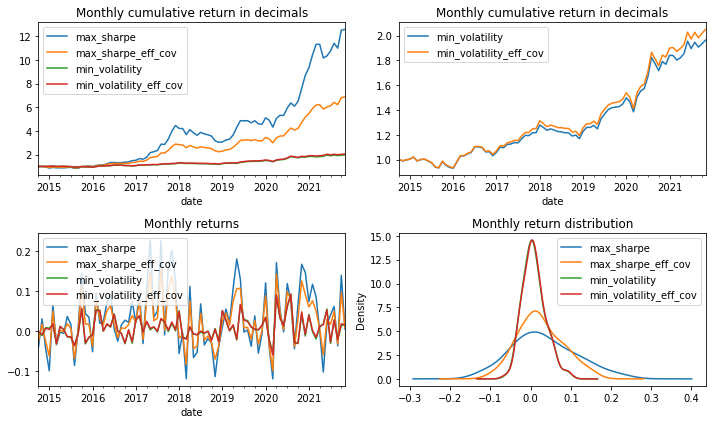

In [ ]:
fig, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
port_return_data.\
add(1).cumprod(axis=0).plot(ax=axes[0,0],
                            title='Monthly cumulative return in decimals')
port_return_data[['min_volatility', 'min_volatility_eff_cov']].\
add(1).cumprod(axis=0).plot(ax=axes[0,1],
                            title='Monthly cumulative return in decimals')
port_return_data.plot(ax=axes[1,0], title='Monthly returns')
port_return_data.plot(ax=axes[1,1], kind='kde',
                      title='Monthly return distribution')
plt.tight_layout()
plt.show()

Well, the maximum Sharpe ratio portfolios outperform the min volatility portfolios in terms of cumulative returns. Meanwhile the best performing porfolio is the maximum Sharpe ratio portfolio which is constructed using sample covariance matrix. Not surprisingly high returns are accompanied with high risks. 
<br> Let's summarize some characteristics/metrics for bitcoin's, S&P 500's, gold's, and the portfolios' returns.

In [ ]:
# Calculating annualized average return and volatility
max_sharpe_anr = (1 + port_return_data['max_sharpe'].mean()) ** 12 - 1
max_sharpe_eff_cov_anr = (1 + port_return_data['max_sharpe_eff_cov'].mean()) ** 12 - 1
min_volatility_anr = (1 + port_return_data['min_volatility'].mean()) ** 12 - 1
min_volatility_eff_cov_anr = (1 + port_return_data['min_volatility_eff_cov'].mean()) ** 12 - 1

max_sharpe_av = port_return_data['max_sharpe'].std() * np.sqrt(12)
max_sharpe_eff_cov_av = port_return_data['max_sharpe_eff_cov'].std() * np.sqrt(12)
min_volatility_av = port_return_data['min_volatility'].std() * np.sqrt(12)
min_volatility_eff_cov_av = port_return_data['min_volatility_eff_cov'].std() * np.sqrt(12)

# Setting risk free rate to current (05.01.2022) US Tbill rate with 4 weeks maturity
rfr = 0.05

# Calculating Sharpe ratio
max_sharpe_sr = (max_sharpe_anr - rfr) / max_sharpe_av
max_sharpe_eff_cov_sr = (max_sharpe_eff_cov_anr - rfr) / max_sharpe_eff_cov_av
min_volatility_sr = (min_volatility_anr - rfr) / min_volatility_av
min_volatility_eff_cov_sr = (min_volatility_eff_cov_anr - rfr) / min_volatility_eff_cov_av

# Calculating downside risk
max_sharpe_dr = port_return_data[port_return_data['max_sharpe']<0]['max_sharpe'].std() * np.sqrt(12)
max_sharpe_eff_cov_dr = port_return_data[port_return_data['max_sharpe_eff_cov']<0]['max_sharpe_eff_cov']\
                        .std() * np.sqrt(12)
min_volatility_dr = port_return_data[port_return_data['min_volatility']<0]['min_volatility']\
                    .std() * np.sqrt(12)
min_volatility_eff_cov_dr = port_return_data[port_return_data['min_volatility_eff_cov']<0]['min_volatility_eff_cov'].std() * np.sqrt(12)

# Calculating VAR with 95 % confidence level
max_sharpe_var = np.percentile(port_return_data['max_sharpe'], 5)
max_sharpe_eff_cov_var = np.percentile(port_return_data['max_sharpe_eff_cov'], 5)
min_volatility_var = np.percentile(port_return_data['min_volatility'], 5)
min_volatility_eff_cov_var = np.percentile(port_return_data['min_volatility_eff_cov'], 5)

# Calculating VAR with 99 % confidence level
max_sharpe_var2 = np.percentile(port_return_data['max_sharpe'], 1)
max_sharpe_eff_cov_var2 = np.percentile(port_return_data['max_sharpe_eff_cov'], 1)
min_volatility_var2 = np.percentile(port_return_data['min_volatility'], 1)
min_volatility_eff_cov_var2 = np.percentile(port_return_data['min_volatility_eff_cov'], 1)

# Calculating conditional VAR for 95 % confidence level
max_sharpe_cvar = port_return_data[port_return_data['max_sharpe'] < max_sharpe_var]['max_sharpe'].mean()
max_sharpe_eff_cov_cvar = port_return_data[port_return_data['max_sharpe_eff_cov'] <                                                                  max_sharpe_eff_cov_var]['max_sharpe_eff_cov'].mean()
min_volatility_cvar = port_return_data[port_return_data['min_volatility'] < 
                                       min_volatility_var]['min_volatility'].mean()
min_volatility_eff_cov_cvar = port_return_data[port_return_data['min_volatility_eff_cov'] < 
                                               min_volatility_eff_cov_var]['min_volatility_eff_cov'].\
                                              mean()

# Calculating conditional VAR for 99 % confidence level
max_sharpe_cvar2 = port_return_data[port_return_data['max_sharpe'] < 
                                    max_sharpe_var2]['max_sharpe'].mean()
max_sharpe_eff_cov_cvar2 = port_return_data[port_return_data['max_sharpe_eff_cov'] <                                                                 max_sharpe_eff_cov_var2]['max_sharpe_eff_cov'].mean()
min_volatility_cvar2 = port_return_data[port_return_data['min_volatility'] <
                                        min_volatility_var2]['min_volatility'].mean()
min_volatility_eff_cov_cvar2 = port_return_data[port_return_data['min_volatility_eff_cov'] < 
                                                min_volatility_eff_cov_var2]['min_volatility_eff_cov'].\
                                               mean()

performance_all = pd.DataFrame({
    'series': ['bitcoin', 's&p 500', 'gold', 'max_sharpe', 
               'max_sharpe_eff_cov', 'min_volatility',
               'min_volatility_eff_cov'],
    'return': [bitcoin_anr, sp500_anr, gold_anr, 
               max_sharpe_anr, max_sharpe_eff_cov_anr, 
               min_volatility_anr, min_volatility_eff_cov_anr],
    'volatility': [bitcoin_av, sp500_av, gold_av,
                   max_sharpe_av, max_sharpe_eff_cov_av, 
                   min_volatility_av, min_volatility_eff_cov_av],
    'Sharpe ratio': [bitcoin_sr, sp500_sr, gold_sr, 
                     max_sharpe_sr, max_sharpe_eff_cov_sr, 
                     min_volatility_sr, min_volatility_eff_cov_sr],
    'downside risk': [bitcoin_dr, sp500_dr, gold_dr,
                      max_sharpe_dr, max_sharpe_eff_cov_dr, 
                      min_volatility_dr, min_volatility_eff_cov_dr]
})

display(performance_all)

risk_all = pd.DataFrame({
    'series': ['bitcoin', 's&p 500', 'gold', 'max_sharpe', 
               'max_sharpe_eff_cov', 'min_volatility',
               'min_volatility_eff_cov'],
    'VAR_95': [bitcoin_var, sp500_var, gold_var, 
               max_sharpe_var, max_sharpe_eff_cov_var, 
               min_volatility_var, min_volatility_eff_cov_var],
    'CVAR_95': [bitcoin_cvar, sp500_cvar, gold_cvar, 
                max_sharpe_cvar, max_sharpe_eff_cov_cvar, 
                min_volatility_cvar, min_volatility_eff_cov_cvar],
    'VAR_99': [bitcoin_var2, sp500_var2, gold_var2,
               max_sharpe_var2, max_sharpe_eff_cov_var2, 
               min_volatility_var2, min_volatility_eff_cov_var2],
    'CVAR_99': [bitcoin_cvar2, sp500_cvar2, gold_cvar2, 
                max_sharpe_cvar2, max_sharpe_eff_cov_cvar2, 
                min_volatility_cvar2, min_volatility_eff_cov_cvar2]
})

display(risk_all)

,series,return,volatility,Sharpe ratio,downside risk
0,bitcoin,1.638161,0.795261,1.997031,0.344481
1,s&p 500,0.139566,0.142689,0.627703,0.111065
2,gold,0.060092,0.125309,0.080535,0.068499
3,max_sharpe,0.473848,0.273708,1.548541,0.122548
4,max_sharpe_eff_cov,0.331561,0.192102,1.465688,0.083614
5,min_volatility,0.103817,0.098076,0.548724,0.044960
6,min_volatility_eff_cov,0.110489,0.098317,0.615242,0.046089


,series,VAR_95,CVAR_95,VAR_99,CVAR_99
0,bitcoin,-0.271310,-0.329163,-0.355131,-0.364116
1,s&p 500,-0.064979,-0.087238,-0.096778,-0.125119
2,gold,-0.053565,-0.065943,-0.071298,-0.072679
3,max_sharpe,-0.095711,-0.110590,-0.119056,-0.119226
4,max_sharpe_eff_cov,-0.061661,-0.076747,-0.085672,-0.099128
5,min_volatility,-0.031357,-0.037063,-0.037959,-0.055519
6,min_volatility_eff_cov,-0.029467,-0.037358,-0.040288,-0.059585


Note:
```
Return, volatility, and downside risk are annulized in the table above. There is 
no percentage value in the tables: all are in decimals.
```
The tables above show that:

1. if one considers Sharpe ratio as a metric for choosing between investments, she/he will definitely select maximum Sharpe ratio portfolio (calculated using sample covariance matrix) out of the all listed portfolio choices (we skip individual assets)

2. if an investor seeks low volatility then minimum volatility portfolio (calculated using sample covariance matrix) is the best choice compared to the other portfolios.